In [16]:
%%javascript
utils.load_extension("collapsible_headings/main")
utils.load_extension("hide_input/main")
utils.load_extension("autosavetime/main")
utils.load_extension("execute_time/ExecuteTime")
utils.load_extension("code_prettify/code_prettify")
utils.load_extension("scroll_down/main")
utils.load_extension("jupyter-js-widgets/extension")

<IPython.core.display.Javascript object>

In [150]:
from sklearn import *
import sklearn
import time
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("max_columns", None)
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from scipy.stats import wilcoxon
import pdb


from sklearn.feature_selection import VarianceThreshold
import zipfile
import os

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


import random

random.seed(0)

from pmlb import fetch_data, regression_dataset_names
from tqdm import tqdm
import time

from category_encoders.target_encoder import TargetEncoder
from category_encoders.m_estimate import MEstimateEncoder

import warnings

warnings.filterwarnings("ignore")

import sktools
from tabulate import tabulate

In [40]:
class TypeSelector(BaseEstimator, TransformerMixin):
    """
    Transformer that filters a type of columns of a given data frame.
    """

    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        # print("Type Selector out shape {}".format(X.select_dtypes(include=[self.dtype]).shape))
        # print(X.select_dtypes(include=[self.dtype]).dtypes)
        return X.select_dtypes(include=[self.dtype])


In [41]:
df = pd.read_csv('data/stackoverflow.csv')

In [69]:
df = df.sample(frac=0.1)

In [70]:
df = df[['Country','DevType','ConvertedSalary']]

In [71]:
cols_enc = ['Country','DevType']

In [174]:
def f(m, q):
    out = np.zeros([len(m), len(q)])

    for i in range(0, len(m)):
        for j in range(0, len(q)):
            # Elastic Net + percentile encoding
            scaler = sklearn.preprocessing.StandardScaler()
            clf = sklearn.linear_model.ElasticNet()
            pe = sktools.QuantileEncoder(cols=cols_enc, quantile=0.50, m=0)

            pipe = Pipeline([
                ("pe", pe),
                ("selector",
                 TypeSelector(np.number)),  # Selects Numerical Columns only
                ("scaler", scaler),
                ("clf", clf),
            ])

            pipe_grid = {
                "pe__m": [m[i]],
                "pe__quantile": [q[j]],
            }

            pipe_cv = GridSearchCV(
                pipe,
                param_grid=pipe_grid,
                n_jobs=-1,
                cv=3,
                scoring="neg_mean_absolute_error",
            )

            pipe_cv.fit(df.drop(columns='ConvertedSalary'), df.ConvertedSalary)

            out[i][j] = pipe_cv.cv_results_['mean_test_score']

    return out

In [188]:
M = np.linspace(0, 20, 50)
Q = np.linspace(0, 1, 50)
Z = f(M, Q)
M, Q = np.meshgrid(M, Q)

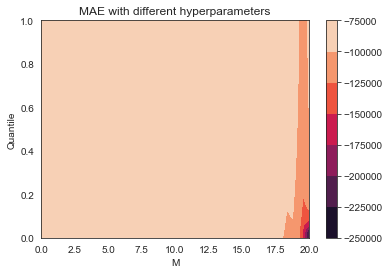

In [189]:
plt.plot()
cp = plt.contourf(M, Q, Z)
plt.colorbar(cp)  #Add a colorbar to a plot
plt.xlabel('M')
plt.ylabel('Quantile')
plt.title('MAE with different hyperparameters')
plt.show()